In [1]:
import numpy as np
import scipy.linalg as la
import itertools as it
import time
import pylab as pl
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from tqdm import tqdm

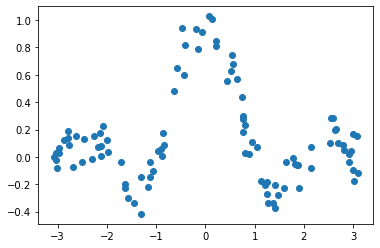

In [2]:
# Test
def noisysincfunction(N, noise):
    ''' noisysincfunction - generate data from the "noisy sinc function"
        % usage
        %     [X, Y] = noisysincfunction(N, noise)
        %
        % input
        %     N: number of data points
        %     noise: standard variation of the noise
        %
        % output
        %     X: (1, N)-matrix uniformly sampled in -2pi, pi
        %     Y: (1, N)-matrix equal to sinc(X) + noise
        %
        % description
        %     Generates N points from the noisy sinc function
        %
        %        X ~ uniformly in [-2pi, pi]
        %        Y = sinc(X) + eps, eps ~ Normal(0, noise.^2)
        %
        % author
        %     Mikio Braun
    '''
    X = np.sort(2 * np.pi * np.random.rand(1, N) ) - np.pi
    Y = np.sinc(X) + noise * np.random.randn(1, N)
    return X.reshape(-1, 1), Y.flatten()
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)
pl.plot(Xtr,Ytr, 'o')

In [3]:
def zero_one_loss(y_true, y_pred):
    ''' your header here!
    '''
    

In [4]:
def mean_absolute_error(y_true, y_pred):
    ''' 
    your code here 
    '''
    loss = np.sum(((y_pred-y_true)**2)**0.5) / len(y_pred)
    return loss

In [5]:
def cv(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    ''' 
    your header here!
    '''
    # TODO progress bar, run time estimation
    length, width = np.shape(X)
    # model = method
    method.cvloss = 1000000
    params_combinations = list(it.product(params['kernel'], params['kernelparameter'], params['regularization']))
    for parameter in tqdm(params_combinations):
        #print(parameter[1])
        model = method(parameter[0], parameter[1], parameter[2])
        for i in range(nrepetitions):
            e = 0
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int')) 
                X_j = X[train]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = model.predict(X[part[j].astype('int')])
                e = e + loss_function(y[part[j].astype('int')], y_pred)
        e = e / (nfolds * nrepetitions)
        #print('Loss:' + str(model.cvloss))
        if e < method.cvloss:
            #print(e)
            method.cvloss = e
            #print('Loss in if:' + str(model.cvloss))
            method.__params = parameter
    #print(method.params)
    method = model.fit(X,y,method.__params[0],method.__params[1],method.__params[2])
    return method

In [6]:
class krr():
    ''' your header here!
    '''
    def __init__(self, kernel='linear', kernelparameter=1, regularization=0):
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.regularization = regularization

    def fit(self, X, y, kernel=False, kernelparameter=False, regularization=False):
        ''' your header here!
        '''
        self.__Xtrain = X
        self.__ytrain = y
        
        if kernel is not False:
            self.kernel = kernel
        if kernelparameter is not False:
            self.kernelparameter = kernelparameter
        if regularization is not False:
            self.regularization = regularization
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        else:
            print("""The following kernel {} is not known. Please use either 'linear' , 'polynomial' or 'gaussian'.""".format(kernel))
        if self.regularization == 0:
            self.__LOOCV()
        
        # calculate optimized alpha
        I_length = len(self.kernelmatrix)
        self.alpha = np.linalg.solve(self.kernelmatrix+self.regularization*np.identity(I_length), self.__ytrain).reshape(-1,len(self.__ytrain))
        
        return self

    def predict(self, X):
        ''' your header here!
        '''
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        # calculate prediction
        y_pred = self.alpha.dot(self.kernelmatrix) # <alpha, kernelmatrix>
        return y_pred.reshape(len(X))
    
    def __linearKernel(self,Y):
        self.kernelmatrix = self.__Xtrain.dot(Y.T)
        
    def __polynomialKernel(self,Y):
        self.kernelmatrix = (self.__Xtrain.dot(Y.T)+1)**self.kernelparameter
        
    def __gaussianKernel(self,Y):
        X_len, X_width = self.__Xtrain.shape
        self.kernelmatrix = np.exp(-(np.diagonal(self.__Xtrain.dot(self.__Xtrain.T)).reshape(X_len, 1)-2*self.__Xtrain.dot(Y.T)+np.diagonal(Y.dot(Y.T)))/(2*(self.kernelparameter**2)))
        
    def __LOOCV(self):
        # Leave-One-Out-Cross-Validation
        # starting squared error
        #min_squared_loss = 1000
        # Eigenvalue decomposition
        squared_loss = []
        L, U = np.linalg.eigh(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        mean_L = np.mean(L)
        I = np.identity(len(L))
        # for faster computation precalculate U.T.y
        UTy = U.T.dot(self.__ytrain)
        # logarithmic distribution with mu = mean_L and sigma = 1
        # create 50 values of C
        # identify C around Kernel eigenvalue means with logarithmic distribution 
        Cs = np.logspace(-10, 10, 50)*mean_L
        for C in Cs: #np.random.lognormal(mean_L,sigma = 1, size = 30):
            ULCI = U.dot(L*I).dot((1/(L + C))*I) # (1/(L + C))*I: inverse of diagonal matrix
            squared_loss.append(np.sum(((self.__ytrain - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2) / len(self.__ytrain))
        self.regularization = Cs[np.argmin(squared_loss)]
                
        # Eigenvalue decomposition
        #L, U = np.linalg.eigh(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        #mean_L = np.mean(L)        
                
        # create candidates
        #C = np.logspace(-10, 10, 50)*mean_L
        
        #UTy = U.T.dot(self.__ytrain)
        # 
        #UL = U.dot(np.diag(L))[None,:,:]
        #LC = np.diag(L)[None,:,:]+C[:,None,None]*I[None,:,:]
        #ULCI = np.linalg.solve(LC,UL)
        
        #calculate all quadratic losses for c candidates
        #c   =    0xnx1-cxnx1 / (1-cxn)
        #epsilon = (np.sum(((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))).reshape(len(C),len(Ytr)))**2, axis = 1) /len(Ytr))
    
        #best_epsilon = epsilon[np.argmin(epsilon)]
    
        #self.regularization = C[np.argmin(epsilon)]        
        
        return self

Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)

pl.figure()
kernels = ['gaussian','polynomial','linear']
titles = ['gaussian','polynomial','linear']
params = [0.5,6,0]
regularizations = [ 0.01,0.01,0.01]
for i in range(3):
    for j in range(2):
        pl.subplot(2,3,1+i+3*j)
        if j==0:
            model = krr(kernel=kernels[i],
                kernelparameter=params[i],
                regularization=regularizations[i])
            model.fit(Xtr,Ytr)
        if j==1:
            model = krr(kernel=kernels[i],
                kernelparameter=params[i],
                regularization=0)
            model.fit(Xtr,Ytr)
        ypred = model.predict(Xte)
        pl.plot(Xtr,Ytr)
        pl.plot(Xte,ypred)
        if j==0 and i == 0:
            pl.ylabel('fixed regularization')
        if j==1 and i == 0:
            pl.ylabel('reg. by efficent cv')
        pl.title( titles[i] )
pl.show()


Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)

pl.figure()
pl.subplot(1,2,1)
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-4,4,20), 'regularization': np.logspace(-2,2,10) }
cvkrr = cv(Xtr, Ytr, krr, params, loss_function=mean_absolute_error, nrepetitions=2)
ypred = cvkrr.predict(Xte)
print('Regularization range: 10**-4 .. 10**4')
print('Gaussian kernel parameter: ', cvkrr.kernelparameter)
print('Regularization paramter: ', cvkrr.regularization)

pl.plot(Xtr,Ytr)
pl.plot(Xte,ypred)

pl.subplot(1,2,2)
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-2,2,10), 'regularization': [0]}
cvkrr = cv(Xtr, Ytr, krr, params, loss_function=mean_absolute_error, nrepetitions=2)
ypred = cvkrr.predict(Xte)
print('Regularization via efficient leave on out')
print('Kernel parameter: ', cvkrr.kernelparameter)
print('Regularization paramter: ', cvkrr.regularization)

pl.plot(Xtr,Ytr)
pl.plot(Xte,ypred)
pl.show()